This spreadsheet is a combination of two model data (N10 and B30 Pro), contains return data and some usage data.
For any cell that is empty, simply means no data available.

We need to predict the records with no data available whether they are return or not return based on records that are confirmed return, right?

In [102]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans # pip install scikit-learn
import re

In [103]:
# load the excel sheet into a Dataframe
xls = pd.ExcelFile("UW_Churn_Pred_Data.xls")
print(f"Sheet Names: {xls.sheet_names}")

Sheet Names: ['Data', 'Legend', 'N10', 'B30 Pro', 'Data Before Feb 13']


In [104]:
# Load the Data Before Feb 13 sheet
data = pd.read_excel(xls, sheet_name="Data Before Feb 13")

In [105]:
# show the first 5 rows of the dataset
print(data.head())

   Device number Product/Model #     Month Office Date Office Time In  \
0      410006072             N10  December  2024-12-19       15:30:00   
1      410006130             N10       NaN         NaT            NaN   
2      410006155             N10       NaN         NaT            NaN   
3      410006171             N10       NaN         NaT            NaN   
4      410006213             N10       NaN         NaT            NaN   

       Source    Type Warranty Defect / Damage type  Responsible Party  \
0  B2C Amazon  Return      Yes            No defect  Customer: Remorse   
1         NaN     NaN      NaN                  NaN                NaN   
2         NaN     NaN      NaN                  NaN                NaN   
3         NaN     NaN      NaN                  NaN                NaN   
4         NaN     NaN      NaN                  NaN                NaN   

  Final Status  Churn                                           sim_info  \
0     Refurb B    1.0  [{"slot_index":0,

In [106]:
# Display basic info about the data
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4995 entries, 0 to 4994
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Device number         4995 non-null   int64         
 1   Product/Model #       4995 non-null   object        
 2   Month                 275 non-null    object        
 3   Office Date           275 non-null    datetime64[ns]
 4   Office Time In        275 non-null    object        
 5   Source                275 non-null    object        
 6   Type                  269 non-null    object        
 7   Warranty              264 non-null    object        
 8   Defect / Damage type  264 non-null    object        
 9   Responsible Party     264 non-null    object        
 10  Final Status          263 non-null    object        
 11  Churn                 274 non-null    float64       
 12  sim_info              4884 non-null   object        
 13  promotion_email   

In [107]:
# check for duplicates
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [108]:
# check for missing values
print(f"Missing Values:\n{data.isnull().sum()}")

Missing Values:
Device number              0
Product/Model #            0
Month                   4720
Office Date             4720
Office Time In          4720
Source                  4720
Type                    4726
Warranty                4731
Defect / Damage type    4731
Responsible Party       4731
Final Status            4732
Churn                   4721
sim_info                 111
promotion_email         1820
register_email           111
interval_date            111
last_boot_date           111
active_date              111
dtype: int64


Only 274 out of 4495 records have a Churn value (4995-4721=274) => most records are missing this key label => these missing values are what we need to predict

In [109]:
print(data['Churn'].value_counts())

Churn
1.0    249
0.0     25
Name: count, dtype: int64


In [110]:
categorical_features = data.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

Categorical Features: ['Product/Model #', 'Month', 'Office Time In', 'Source', 'Type', 'Warranty', 'Defect / Damage type', 'Responsible Party', 'Final Status', 'sim_info', 'interval_date', 'last_boot_date', 'active_date']
Numerical Features: ['Device number', 'Churn', 'promotion_email', 'register_email']


# Analyzing Categorical Features

In [111]:
features = ['Defect / Damage type','Final Status']
for col in features:
    print(f"--- {col} ---")
    print(data[col].value_counts(dropna=False))  # Includes NaN values in the count
    print("\n")

--- Defect / Damage type ---
Defect / Damage type
NaN                         4731
No defect                    234
Hardware                       9
Display or TP                  6
Device cannot power on         3
Camera                         2
Microphone/Speaker             2
Power (non battery)            2
LCD                            1
Receive/Transmit/Antenna       1
Software                       1
Buttons Physical               1
Battery                        1
Speaker                        1
Name: count, dtype: int64


--- Final Status ---
Final Status
NaN                                                   4732
Refurb B                                               141
Refurb A                                                60
New                                                     31
SBC                                                     12
Defective - Pending to repair and replacement sent       9
Send back to HK                                          4
Defective - P

--- Product/Model # ---
Product/Model #
N10        2632
B30 Pro    2354
B30           9
Name: count, dtype: int64


--- Source ---
Source
NaN                4720
B2C Amazon          178
B2C NUU Website      97
Name: count, dtype: int64


--- Type ---
Type
NaN       4726
Return     243
Repair      26
Name: count, dtype: int64


--- Warranty ---
Warranty
NaN    4731
Yes     256
No        8
Name: count, dtype: int64




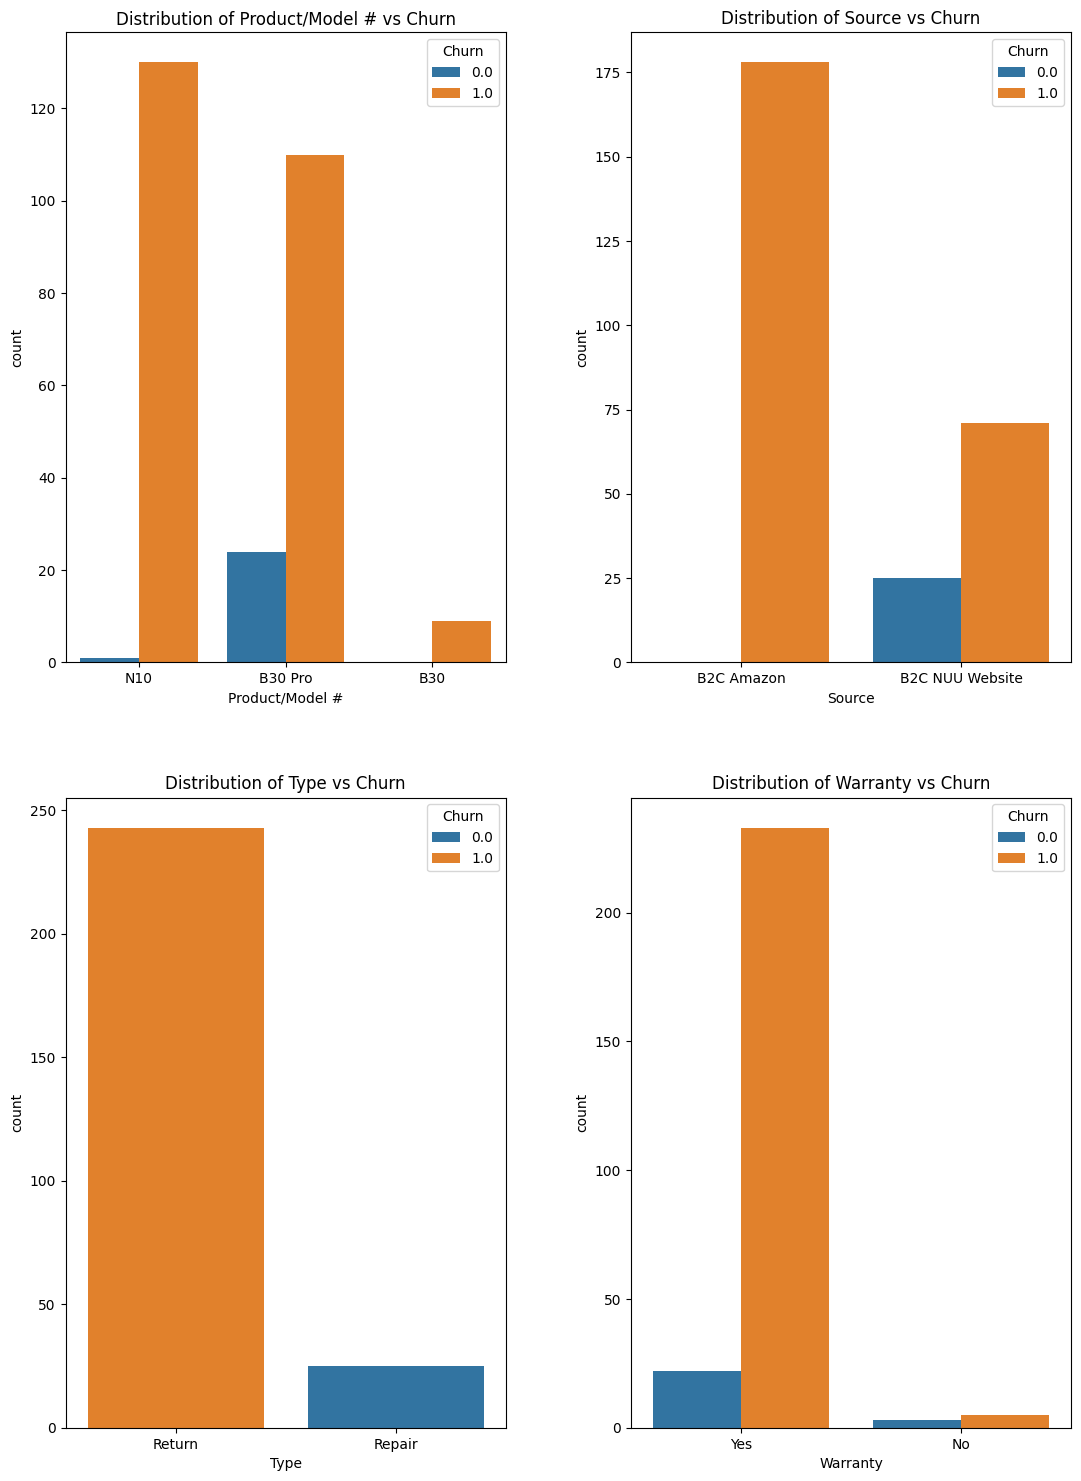

In [112]:
# List of categorical features to visualize
features = ['Product/Model #', 'Source', 'Type', 'Warranty']

for col in features:
    print(f"--- {col} ---")
    print(data[col].value_counts(dropna=False))  # Includes NaN values in the count
    print("\n")

# Create a figure with subplots
n_cols = 2  # Number of columns in the grid
n_rows = (len(features) + 1) // n_cols  # Calculate number of rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 16))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through the features and plot each one
for i, col in enumerate(features):
    sns.countplot(data=data, x=col, hue='Churn', ax=axes[i])  # Plot on the i-th subplot
    axes[i].set_title(f'Distribution of {col} vs Churn')

# Remove empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout(pad=5)
plt.show()

--- Month ---
Month
January      54
February     32
March         0
April         6
May           8
June         50
July         19
August       23
September     5
October       8
November      5
December     65
Name: count, dtype: int64




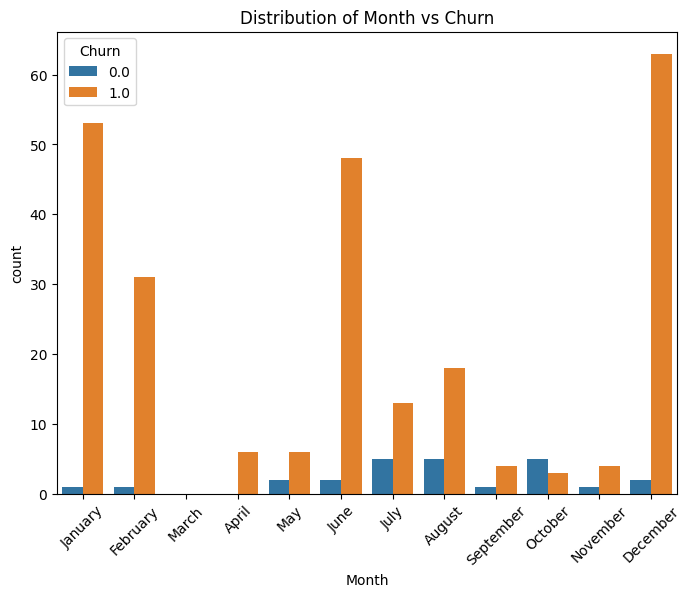

In [113]:
# Define the order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

feature = 'Month'

# Convert the 'Month' column to a categorical type with the specified order
data[feature] = pd.Categorical(data[feature], categories=month_order, ordered=True)

# Print the value counts sorted by the defined month order
print(f"--- {feature} ---")
sorted_counts = data[feature].value_counts(dropna=False).reindex(month_order)
print(sorted_counts)
print("\n")

# Plotting the countplot
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x=feature, hue='Churn')  # Color by Churn
plt.title(f'Distribution of {feature} vs Churn')
plt.xticks(rotation=45)
plt.show()

--- Responsible Party ---
Responsible Party
NaN                    4731
Customer: Remorse       232
Factory: Defective       14
Tested but No Issue       9
Customer: Damaged         8
Paid RMA                  1
Name: count, dtype: int64




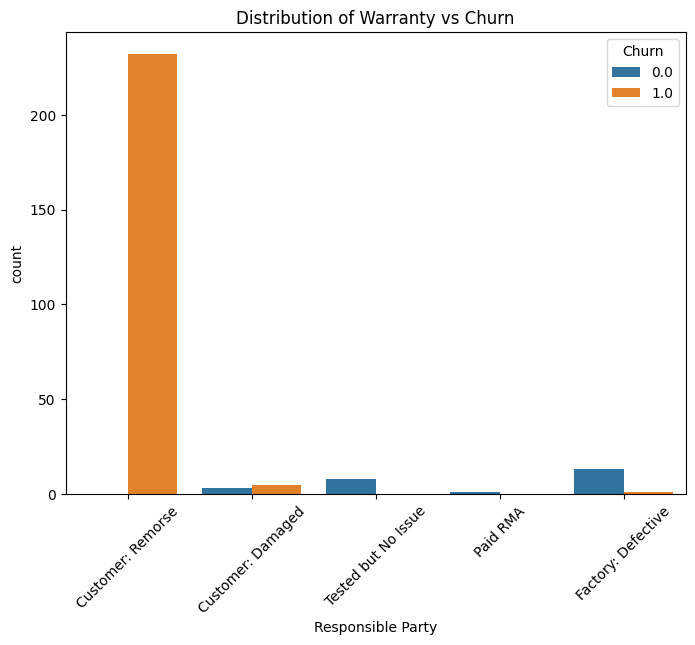

In [114]:
feature = 'Responsible Party'
# Display the count of unique values for each categorical feature
print(f"--- {feature} ---")
print(data[feature].value_counts(dropna=False))  # Includes NaN values in the count
print("\n")

plt.figure(figsize=(8, 6))
sns.countplot(data=data, x=feature, hue='Churn')  # Color by Churn
plt.title(f'Distribution of {col} vs Churn')
plt.xticks(rotation=45)
plt.show()

--- Office Time In ---
Office Time In
NaN         4720
07:50:00      41
07:40:00      27
07:45:00      21
15:45:00      17
16:00:00      17
08:00:00      15
15:30:00       9
07:55:00       9
15:50:00       8
07:25:00       8
14:00:00       8
14:30:00       8
13:40:00       8
14:40:00       7
15:12:00       7
15:00:00       6
16:05:00       6
14:15:00       6
15:40:00       6
14:50:00       6
14:10:00       5
07:30:00       4
13:45:00       4
16:15:00       3
10:45:00       2
2:00 P.M       2
07:20:00       2
3:40 P.M       2
14:25:00       1
7:40 A.M       1
08:10:00       1
09:49:00       1
09:30:00       1
08:15:00       1
1230 PM        1
10:20:00       1
14:57:00       1
08:40:00       1
11:00:00       1
Name: count, dtype: int64




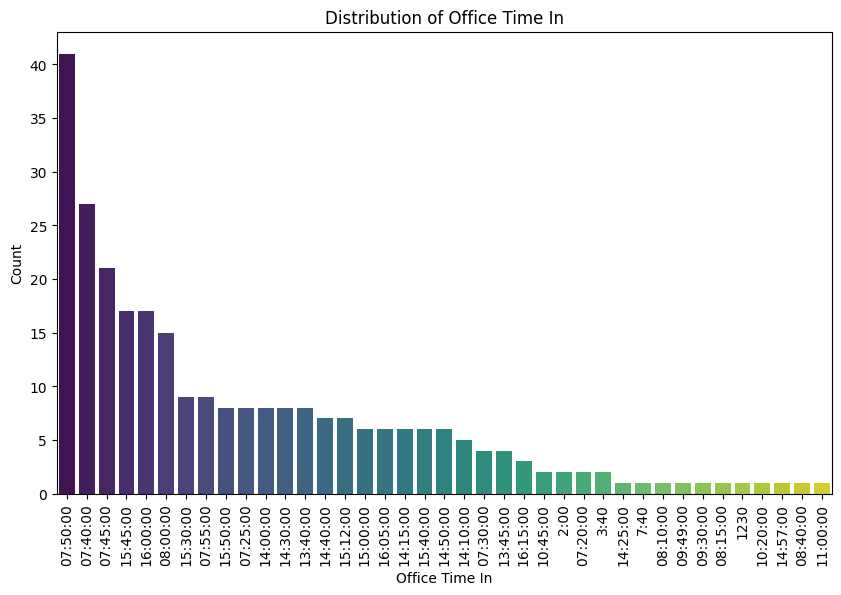

In [122]:
from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="UnknownTimezoneWarning")
warnings.filterwarnings("ignore", category=FutureWarning)

feature = 'Office Time In'

print(f"--- {feature} ---")
print(data[feature].value_counts(dropna=False))  # Includes NaN values in the count
print("\n")

def clean_time_format(time_str):
    if isinstance(time_str, str):
        # Remove any timezone components (e.g., 'M' in '2:00 PM M')
        time_str = time_str.split(' ')[0]  # Keep only the time portion
        try:
            return datetime.strptime(time_str, '%I:%M %p').strftime('%H:%M:%S')
        except ValueError:
            return time_str  # Return original if it doesn't match expected format
    return time_str  # Return NaN as is

# Apply the cleaning function
data['Office Time In'] = data['Office Time In'].apply(clean_time_format)

# Plot the distribution of 'Office Time In'
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Office Time In', order=data['Office Time In'].value_counts().index, palette='viridis')
plt.xticks(rotation=90)  # Rotate x-axis labels to avoid overlap
plt.title('Distribution of Office Time In')
plt.xlabel('Office Time In')
plt.ylabel('Count')
plt.show()

# Analyzing Numerical Features

In [116]:
# Summary statistics for numerical features
print("Numerical Features Summary:")
print(data.describe())

Numerical Features Summary:
       Device number          Office Date       Churn  promotion_email  \
count   4.995000e+03                  275  274.000000      3175.000000   
mean    3.722009e+08  2024-10-19 04:48:00    0.908759         0.215748   
min     3.300054e+08  2024-04-03 00:00:00    0.000000         0.000000   
25%     3.300432e+08  2024-07-15 12:00:00    1.000000         0.000000   
50%     4.100101e+08  2024-12-09 00:00:00    1.000000         0.000000   
75%     4.100461e+08  2025-01-14 00:00:00    1.000000         0.000000   
max     4.100997e+08  2025-02-13 00:00:00    1.000000         1.000000   
std     3.994723e+07                  NaN    0.288478         0.411405   

       register_email  
count     4884.000000  
mean         0.608313  
min          0.000000  
25%          0.000000  
50%          1.000000  
75%          1.000000  
max          1.000000  
std          0.488177  


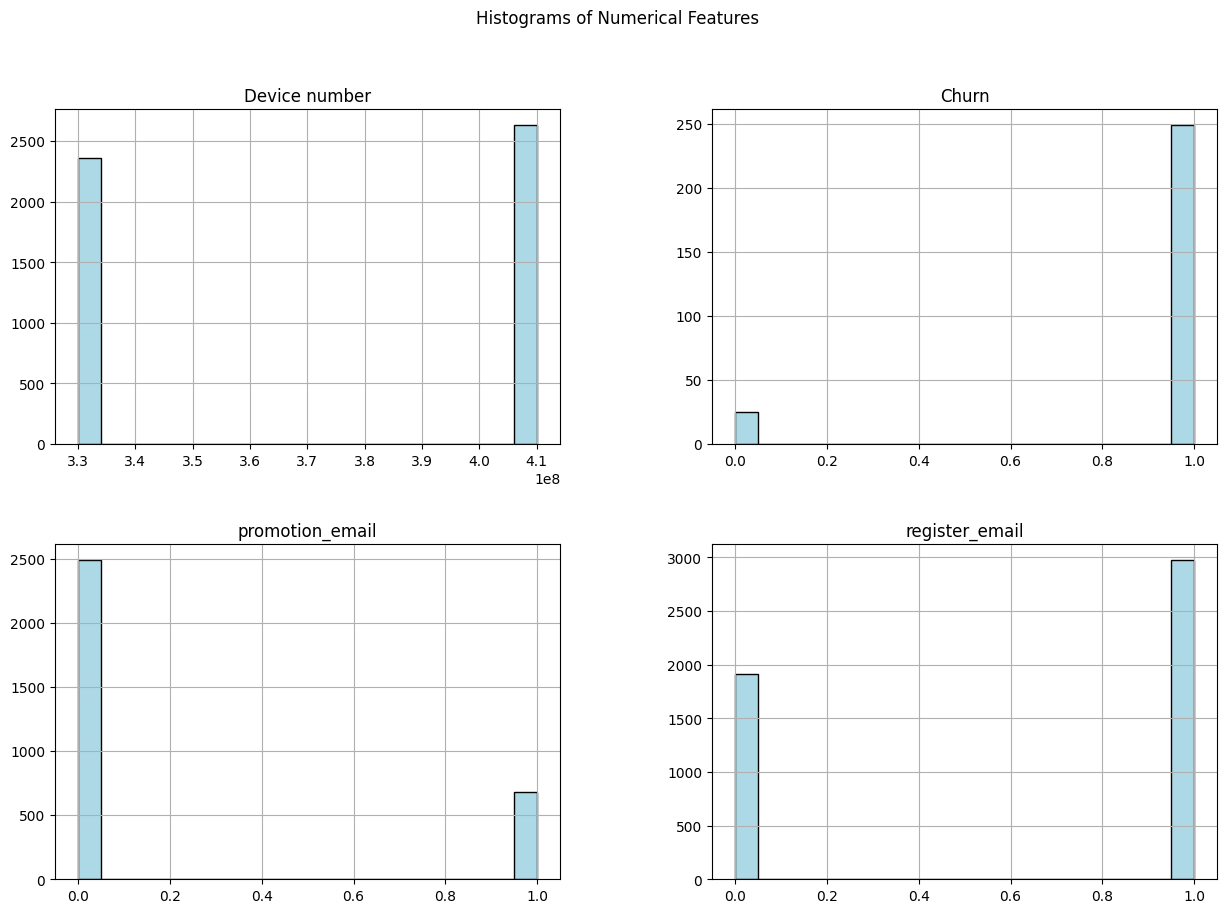

In [117]:
# Plot histograms for numerical features
data[numerical_features].hist(bins=20, figsize=(15, 10), color='lightblue', edgecolor='black')
plt.suptitle('Histograms of Numerical Features')
plt.show()

                 Device number     Churn  promotion_email  register_email
Device number         1.000000  0.277954        -0.052298       -0.477589
Churn                 0.277954  1.000000         0.058762       -0.141441
promotion_email      -0.052298  0.058762         1.000000        0.644199
register_email       -0.477589 -0.141441         0.644199        1.000000


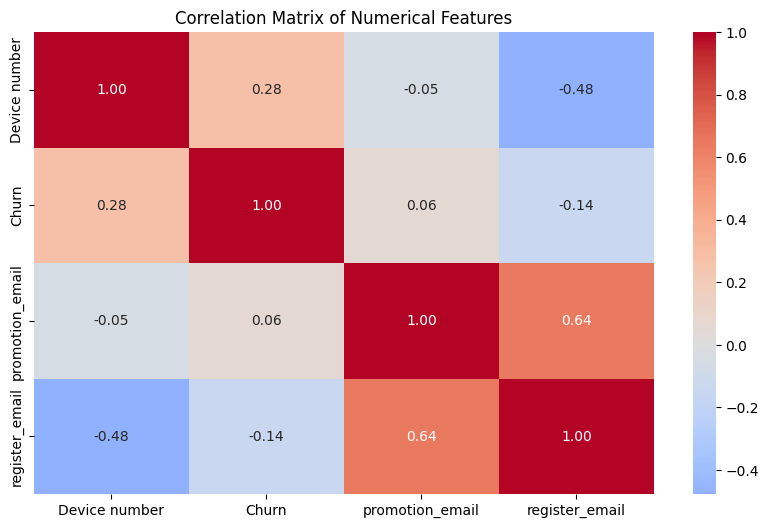

In [118]:
# correlation matrix for numerical features
corr_matrix = data[numerical_features].corr()

print(corr_matrix)

# Plotting the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()